In [ ]:
%matplotlib inline

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu115 torchvision==0.12.0+cu115 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html

Mounted at /content/drive
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/keyword_spotting
dataset/  main.py   models/     __pycache__/  SpeechCommands/
.git/     metrics/  notebooks/  README.md     utilsFunc.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 8.9 MB/s eta 0:02:26tcmalloc: large alloc 1147494400 bytes == 0x3926e000 @  0x7fe8b3239615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.3 MB/s eta 0:13:49tcmalloc: large alloc 1434370048 bytes == 0x7d8c4000 @  0x7fe8b3239615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.spectrogram_model import spectrogram_model
from utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

In [ ]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

Using cuda


## Downloading and setting up the dataset

In [ ]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'train_set' not in locals():  
        train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

training & test sets finished in  0:01:52.691787


## Let's visualize the data !

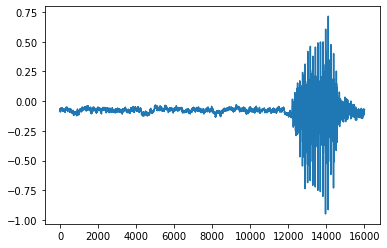

In [ ]:
plt.plot(storage['waveform'].t().numpy())

(241, 98)


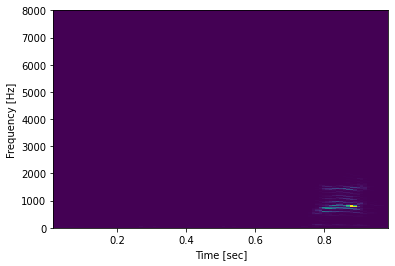

In [ ]:
from scipy import signal
from scipy.fft import fftshift

fe=16000
noverlap=int(20e-3*fe)
nperseg=int(30e-3*fe)
f, t, Sxx = signal.spectrogram(storage['waveform'][0], fe,noverlap=noverlap,nperseg=nperseg)
plt.pcolormesh(t, f, Sxx)
print(Sxx.shape)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:

n_mels=50

win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

size of tensor should be  98.0


### Spectrogram transform

Shape of spectrogram: torch.Size([1, 241, 101])


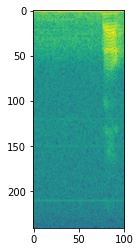

In [ ]:
spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length)

spectrogram=spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure()
plt.imshow(spectrogram.log2()[0].numpy())

## Resampling the data and setting the transform

In [ ]:
layers =[]
layers.append(spectrogram_transform)

storage['transform'] = nn.Sequential(*layers)

waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

torch.Size([1, 241, 101])


## Setting up the test and train loader

In [ ]:
batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['train_loader']  = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the network

In [ ]:
storage['model'] = spectrogram_model(input_shape=waveform_size, n_output=len(train_set.labels))
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())

Number of parameters: 5903043


## Define the optimizer, loss function & metrics

In [ ]:
# Define the Optimizer
lr=0.001 
storage['optimizer'] = optim.Adam(storage['model'].parameters(), lr=lr, weight_decay=0.0001)
storage['scheduler'] = optim.lr_scheduler.StepLR(storage['optimizer'], step_size=20,
                                      gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
#Define the loss Function
storage['lossFunc']=F.cross_entropy
#Define the metrics :
storage['metrics']=metrics.countCorrectOutput

## Define the log interval and epochs

In [ ]:
storage['log_interval'] = 20
storage['n_epoch'] = 20

storage['pbar_update']  = 1 / (len(storage['train_loader']) + len(storage['test_loader']))
storage['losses'] = []
# The transform needs to live on the same device as the model and the data.

storage['transform'] = storage['transform'].to(storage['device'])

In [15]:
with timeThat('Main program') :
    with tqdm(total=storage['n_epoch']) as pbar:
        storage['pbar']=pbar
        for epoch in range(1, storage['n_epoch'] + 1):
            storage['epoch']=epoch
            train(storage)
            test(storage)
            storage['scheduler'].step()

  0%|          | 0.0020833333333333333/100 [00:07<79:05:17, 2847.24s/it] 

Train Epoch: 100 [0/84843 (0%)]	Loss: 5.365181


  0%|          | 0.021875/100 [00:12<9:14:01, 332.49s/it]            

Train Epoch: 100 [2000/84843 (2%)]	Loss: 3.691789


  0%|          | 0.04270833333333336/100 [00:18<9:01:57, 325.32s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 3.556154


  0%|          | 0.06354166666666675/100 [00:23<9:08:09, 329.11s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 3.543329


  0%|          | 0.084375/100 [00:29<9:25:12, 339.41s/it]           

Train Epoch: 100 [8000/84843 (9%)]	Loss: 3.497889


  0%|          | 0.10520833333333326/100 [00:35<9:13:50, 332.65s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 3.510187


  0%|          | 0.12604166666666652/100 [00:41<9:15:45, 333.88s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 3.475865


  0%|          | 0.14687499999999978/100 [00:46<9:25:35, 339.85s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 3.515487


  0%|          | 0.16770833333333304/100 [00:52<9:18:47, 335.84s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 3.468681


  0%|          | 0.1885416666666663/100 [00:58<9:15:51, 334.15s/it] 

Train Epoch: 100 [18000/84843 (21%)]	Loss: 3.589459


  0%|          | 0.20937499999999956/100 [01:03<9:35:59, 346.32s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 3.377227


  0%|          | 0.23020833333333282/100 [01:09<9:15:13, 333.91s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 3.519300


  0%|          | 0.2510416666666661/100 [01:15<9:26:19, 340.65s/it] 

Train Epoch: 100 [24000/84843 (28%)]	Loss: 3.514695


  0%|          | 0.27187499999999937/100 [01:21<9:20:26, 337.18s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 3.393906


  0%|          | 0.2927083333333326/100 [01:26<9:32:56, 344.77s/it] 

Train Epoch: 100 [28000/84843 (33%)]	Loss: 3.354492


  0%|          | 0.3135416666666659/100 [01:32<9:27:28, 341.56s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 3.354853


  0%|          | 0.33437499999999915/100 [01:38<9:28:33, 342.28s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 3.418800


  0%|          | 0.3552083333333324/100 [01:44<9:24:07, 339.68s/it] 

Train Epoch: 100 [34000/84843 (40%)]	Loss: 3.353413


  0%|          | 0.37604166666666566/100 [01:50<9:37:53, 348.04s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 3.362147


  0%|          | 0.3968749999999989/100 [01:55<9:30:21, 343.58s/it] 

Train Epoch: 100 [38000/84843 (45%)]	Loss: 3.288135


  0%|          | 0.4177083333333322/100 [02:01<9:29:41, 343.25s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 3.302314


  0%|          | 0.43854166666666544/100 [02:07<9:41:04, 350.18s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 3.273492


  0%|          | 0.4593749999999987/100 [02:13<9:29:28, 343.26s/it] 

Train Epoch: 100 [44000/84843 (52%)]	Loss: 3.226577


  0%|          | 0.48020833333333196/100 [02:19<9:51:12, 356.43s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 3.000656


  1%|          | 0.5010416666666653/100 [02:25<9:35:27, 347.01s/it] 

Train Epoch: 100 [48000/84843 (57%)]	Loss: 3.414554


  1%|          | 0.5218749999999996/100 [02:31<9:45:29, 353.14s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 3.143639


  1%|          | 0.542708333333334/100 [02:37<9:45:58, 353.51s/it] 

Train Epoch: 100 [52000/84843 (61%)]	Loss: 3.023569


  1%|          | 0.5635416666666684/100 [02:43<9:40:54, 350.52s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 3.141879


  1%|          | 0.5843750000000028/100 [02:49<9:27:34, 342.55s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 2.943618


  1%|          | 0.6052083333333371/100 [02:55<9:42:16, 351.49s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 3.037185


  1%|          | 0.6260416666666715/100 [03:01<9:48:38, 355.41s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 2.868539


  1%|          | 0.6468750000000059/100 [03:07<9:43:47, 352.55s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 3.117603


  1%|          | 0.6677083333333402/100 [03:13<9:46:21, 354.18s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 3.007397


  1%|          | 0.6885416666666746/100 [03:19<9:37:42, 349.03s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 2.974979


  1%|          | 0.709375000000009/100 [03:25<9:38:58, 349.87s/it] 

Train Epoch: 100 [68000/84843 (80%)]	Loss: 2.914334


  1%|          | 0.7302083333333433/100 [03:31<9:33:39, 346.73s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 2.639714


  1%|          | 0.7510416666666777/100 [03:37<9:38:20, 349.63s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 2.745527


  1%|          | 0.7718750000000121/100 [03:43<9:32:57, 346.45s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 2.867708


  1%|          | 0.7927083333333464/100 [03:49<9:35:09, 347.85s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 2.812952


  1%|          | 0.8135416666666808/100 [03:55<9:38:46, 350.12s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 2.881687


  1%|          | 0.8343750000000152/100 [04:01<9:43:06, 352.81s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 2.690004


  1%|          | 0.8552083333333496/100 [04:06<9:34:44, 347.82s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 2.736423


  1%|          | 0.8760416666666839/100 [04:12<9:35:07, 348.13s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 2.443051


  1%|          | 0.9989583333333567/100 [04:33<3:11:57, 116.34s/it]


Test Epoch: 100	Accuracy: 2720/11005 (25%)



  1%|          | 1.00104166666669/100 [04:33<3:28:01, 126.08s/it]  

Train Epoch: 100 [0/84843 (0%)]	Loss: 2.697072


  1%|          | 1.021875000000022/100 [04:38<8:27:11, 307.46s/it] 

Train Epoch: 100 [2000/84843 (2%)]	Loss: 2.609650


  1%|          | 1.0427083333333542/100 [04:43<8:29:08, 308.71s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 2.555384


  1%|          | 1.0635416666666864/100 [04:48<8:28:45, 308.53s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 2.607966


  1%|          | 1.0843750000000185/100 [04:53<8:29:56, 309.32s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 2.787500


  1%|          | 1.1052083333333507/100 [04:58<8:30:17, 309.59s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 2.583652


  1%|          | 1.1260416666666828/100 [05:03<8:30:13, 309.62s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 2.660487


  1%|          | 1.146875000000015/100 [05:08<8:31:13, 310.29s/it] 

Train Epoch: 100 [14000/84843 (16%)]	Loss: 2.513317


  1%|          | 1.1677083333333471/100 [05:14<8:29:40, 309.42s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 2.694285


  1%|          | 1.1885416666666793/100 [05:19<8:28:07, 308.54s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 2.482432


  1%|          | 1.2093750000000114/100 [05:24<8:31:29, 310.65s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 2.317509


  1%|          | 1.2302083333333436/100 [05:29<8:31:10, 310.52s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 2.405572


  1%|▏         | 1.2510416666666757/100 [05:34<8:30:58, 310.47s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 2.379084


  1%|▏         | 1.2718750000000079/100 [05:39<8:31:35, 310.91s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 2.645655


  1%|▏         | 1.29270833333334/100 [05:44<8:26:57, 308.16s/it]  

Train Epoch: 100 [28000/84843 (33%)]	Loss: 2.509964


  1%|▏         | 1.3135416666666722/100 [05:49<8:28:47, 309.34s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 2.561352


  1%|▏         | 1.3343750000000043/100 [05:54<8:27:16, 308.48s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 2.268976


  1%|▏         | 1.3552083333333365/100 [05:59<8:29:40, 310.01s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 2.370052


  1%|▏         | 1.3760416666666686/100 [06:05<8:27:55, 309.01s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 2.383431


  1%|▏         | 1.3968750000000008/100 [06:10<8:27:08, 308.60s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 2.316836


  1%|▏         | 1.417708333333333/100 [06:15<8:28:48, 309.68s/it] 

Train Epoch: 100 [40000/84843 (47%)]	Loss: 2.703203


  1%|▏         | 1.438541666666665/100 [06:20<8:27:14, 308.78s/it] 

Train Epoch: 100 [42000/84843 (49%)]	Loss: 2.430089


  1%|▏         | 1.4593749999999972/100 [06:25<8:27:33, 309.04s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 2.488937


  1%|▏         | 1.4802083333333294/100 [06:30<8:27:41, 309.19s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 2.459440


  2%|▏         | 1.5010416666666615/100 [06:35<8:27:20, 309.04s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 2.230049


  2%|▏         | 1.5218749999999936/100 [06:40<8:26:51, 308.82s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 2.226089


  2%|▏         | 1.5427083333333258/100 [06:45<8:27:07, 309.04s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 2.360394


  2%|▏         | 1.563541666666658/100 [06:50<8:27:12, 309.16s/it] 

Train Epoch: 100 [54000/84843 (64%)]	Loss: 2.374339


  2%|▏         | 1.58437499999999/100 [06:55<8:26:17, 308.67s/it]  

Train Epoch: 100 [56000/84843 (66%)]	Loss: 2.325852


  2%|▏         | 1.6052083333333222/100 [07:01<8:28:07, 309.85s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 2.126423


  2%|▏         | 1.6260416666666544/100 [07:06<8:25:57, 308.59s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 2.529297


  2%|▏         | 1.6468749999999865/100 [07:11<8:26:17, 308.86s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 2.380111


  2%|▏         | 1.6677083333333187/100 [07:16<8:25:08, 308.22s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 2.619125


  2%|▏         | 1.6885416666666508/100 [07:21<8:26:53, 309.36s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 2.817047


  2%|▏         | 1.709374999999983/100 [07:26<8:25:37, 308.65s/it] 

Train Epoch: 100 [68000/84843 (80%)]	Loss: 2.265111


  2%|▏         | 1.7302083333333151/100 [07:31<8:27:03, 309.60s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 2.296164


  2%|▏         | 1.7510416666666473/100 [07:36<8:26:30, 309.32s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.977613


  2%|▏         | 1.7718749999999794/100 [07:41<8:26:26, 309.35s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 2.062536


  2%|▏         | 1.7927083333333116/100 [07:46<8:25:46, 309.00s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 2.323817


  2%|▏         | 1.8135416666666437/100 [07:51<8:25:14, 308.74s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 2.069813


  2%|▏         | 1.8343749999999759/100 [07:57<8:24:58, 308.65s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 2.180080


  2%|▏         | 1.855208333333308/100 [08:02<8:26:21, 309.56s/it] 

Train Epoch: 100 [82000/84843 (97%)]	Loss: 2.066956


  2%|▏         | 1.8760416666666402/100 [08:07<8:25:07, 308.87s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 2.228802


  2%|▏         | 1.9989583333332999/100 [08:22<3:04:45, 113.12s/it]


Test Epoch: 100	Accuracy: 4033/11005 (37%)



  2%|▏         | 2.0010416666666333/100 [08:22<3:19:55, 122.40s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 2.351244


  2%|▏         | 2.0218749999999654/100 [08:27<8:24:01, 308.66s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 2.406981


  2%|▏         | 2.0427083333332976/100 [08:32<8:23:56, 308.67s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 2.106517


  2%|▏         | 2.0635416666666297/100 [08:37<8:23:01, 308.18s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 2.003391


  2%|▏         | 2.084374999999962/100 [08:42<8:23:59, 308.84s/it] 

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.806341


  2%|▏         | 2.105208333333294/100 [08:47<8:23:59, 308.90s/it] 

Train Epoch: 100 [10000/84843 (12%)]	Loss: 2.196549


  2%|▏         | 2.126041666666626/100 [08:52<8:24:47, 309.45s/it] 

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.927570


  2%|▏         | 2.1468749999999583/100 [08:58<8:24:01, 309.05s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 2.095706


  2%|▏         | 2.1677083333332905/100 [09:03<8:22:47, 308.36s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 2.143733


  2%|▏         | 2.1885416666666226/100 [09:08<8:22:41, 308.37s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 2.032752


  2%|▏         | 2.209374999999955/100 [09:13<8:23:19, 308.82s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 2.033256


  2%|▏         | 2.230208333333287/100 [09:18<8:22:19, 308.27s/it] 

Train Epoch: 100 [22000/84843 (26%)]	Loss: 2.039706


  2%|▏         | 2.251041666666619/100 [09:23<8:22:25, 308.40s/it] 

Train Epoch: 100 [24000/84843 (28%)]	Loss: 2.245552


  2%|▏         | 2.2718749999999512/100 [09:28<8:22:28, 308.49s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 2.041081


  2%|▏         | 2.2927083333332834/100 [09:33<8:21:58, 308.26s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 2.332915


  2%|▏         | 2.3135416666666155/100 [09:38<8:22:52, 308.87s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 2.019742


  2%|▏         | 2.3343749999999477/100 [09:43<8:22:31, 308.72s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.969576


  2%|▏         | 2.35520833333328/100 [09:48<8:23:19, 309.28s/it]  

Train Epoch: 100 [34000/84843 (40%)]	Loss: 2.035573


  2%|▏         | 2.376041666666612/100 [09:54<8:23:07, 309.23s/it] 

Train Epoch: 100 [36000/84843 (42%)]	Loss: 2.258145


  2%|▏         | 2.396874999999944/100 [09:59<8:22:52, 309.13s/it] 

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.857985


  2%|▏         | 2.4177083333332763/100 [10:04<8:23:05, 309.34s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 2.138605


  2%|▏         | 2.4385416666666084/100 [10:09<8:22:24, 308.98s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 2.201415


  2%|▏         | 2.4593749999999406/100 [10:14<8:22:49, 309.31s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 2.141176


  2%|▏         | 2.4802083333332727/100 [10:19<8:23:23, 309.72s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 2.336352


  3%|▎         | 2.501041666666605/100 [10:24<8:23:13, 309.68s/it] 

Train Epoch: 100 [48000/84843 (57%)]	Loss: 2.016545


  3%|▎         | 2.521874999999937/100 [10:29<8:22:44, 309.45s/it] 

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.849965


  3%|▎         | 2.542708333333269/100 [10:34<8:21:39, 308.85s/it] 

Train Epoch: 100 [52000/84843 (61%)]	Loss: 2.088253


  3%|▎         | 2.5635416666666013/100 [10:39<8:22:37, 309.50s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 2.041548


  3%|▎         | 2.5843749999999335/100 [10:45<8:21:29, 308.88s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 2.148468


  3%|▎         | 2.6052083333332656/100 [10:50<8:21:02, 308.67s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.909530


  3%|▎         | 2.6260416666665978/100 [10:55<8:21:01, 308.72s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 2.185641


  3%|▎         | 2.64687499999993/100 [11:00<8:20:46, 308.64s/it]  

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.920369


  3%|▎         | 2.667708333333262/100 [11:05<8:20:44, 308.68s/it] 

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.806226


  3%|▎         | 2.688541666666594/100 [11:10<8:20:48, 308.79s/it] 

Train Epoch: 100 [66000/84843 (78%)]	Loss: 2.082908


  3%|▎         | 2.7093749999999264/100 [11:15<8:22:35, 309.95s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.888826


  3%|▎         | 2.7302083333332585/100 [11:20<8:19:43, 308.25s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.822531


  3%|▎         | 2.7510416666665907/100 [11:25<8:21:07, 309.18s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.812663


  3%|▎         | 2.771874999999923/100 [11:30<8:20:59, 309.17s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.930358


  3%|▎         | 2.792708333333255/100 [11:35<8:22:23, 310.10s/it] 

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.715509


  3%|▎         | 2.813541666666587/100 [11:41<8:20:06, 308.75s/it] 

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.887858


  3%|▎         | 2.8343749999999193/100 [11:46<8:20:54, 309.32s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.807960


  3%|▎         | 2.8552083333332514/100 [11:51<8:20:04, 308.86s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.553654


  3%|▎         | 2.8760416666665836/100 [11:56<8:18:42, 308.09s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 2.230425


  3%|▎         | 2.9989583333332432/100 [12:11<3:03:14, 113.34s/it]


Test Epoch: 100	Accuracy: 4617/11005 (42%)



  3%|▎         | 3.0010416666665765/100 [12:11<3:18:30, 122.79s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.764524


  3%|▎         | 3.0218749999999086/100 [12:16<8:18:28, 308.41s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.862161


  3%|▎         | 3.0427083333332408/100 [12:21<8:19:06, 308.87s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.588374


  3%|▎         | 3.063541666666573/100 [12:26<8:18:59, 308.86s/it] 

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.517108


  3%|▎         | 3.084374999999905/100 [12:31<8:19:19, 309.12s/it] 

Train Epoch: 100 [8000/84843 (9%)]	Loss: 2.053216


  3%|▎         | 3.105208333333237/100 [12:36<8:19:36, 309.37s/it] 

Train Epoch: 100 [10000/84843 (12%)]	Loss: 1.895461


  3%|▎         | 3.1260416666665694/100 [12:41<8:18:32, 308.77s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.837352


  3%|▎         | 3.1468749999999015/100 [12:47<8:19:23, 309.37s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.629933


  3%|▎         | 3.1677083333332337/100 [12:52<8:18:16, 308.75s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 2.250424


  3%|▎         | 3.188541666666566/100 [12:57<8:19:40, 309.68s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.937226


  3%|▎         | 3.209374999999898/100 [13:02<8:17:58, 308.69s/it] 

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.875273


  3%|▎         | 3.23020833333323/100 [13:07<8:18:25, 309.04s/it]  

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.623531


  3%|▎         | 3.2510416666665622/100 [13:12<8:18:48, 309.34s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.739888


  3%|▎         | 3.2718749999998944/100 [13:17<8:19:05, 309.59s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 2.014950


  3%|▎         | 3.2927083333332265/100 [13:22<8:18:16, 309.14s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 2.337234


  3%|▎         | 3.3135416666665587/100 [13:27<8:18:13, 309.18s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.758544


  3%|▎         | 3.334374999999891/100 [13:32<8:17:41, 308.92s/it] 

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.627564


  3%|▎         | 3.355208333333223/100 [13:37<8:18:14, 309.32s/it] 

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.925584


  3%|▎         | 3.376041666666555/100 [13:43<8:17:48, 309.12s/it] 

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.620477


  3%|▎         | 3.3968749999998873/100 [13:48<8:18:56, 309.89s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.692443


  3%|▎         | 3.4177083333332194/100 [13:53<8:18:16, 309.54s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.959107


  3%|▎         | 3.4385416666665516/100 [13:58<8:16:36, 308.57s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.608081


  3%|▎         | 3.4593749999998837/100 [14:03<8:17:13, 309.03s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.784142


  3%|▎         | 3.480208333333216/100 [14:08<8:17:38, 309.35s/it] 

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.740178


  4%|▎         | 3.501041666666548/100 [14:13<8:17:59, 309.63s/it] 

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.824803


  4%|▎         | 3.52187499999988/100 [14:18<8:16:08, 308.55s/it]  

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.867793


  4%|▎         | 3.5427083333332123/100 [14:23<8:16:55, 309.10s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.778586


  4%|▎         | 3.5635416666665445/100 [14:28<8:16:38, 309.00s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.616534


  4%|▎         | 3.5843749999998766/100 [14:33<8:15:43, 308.50s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.687239


  4%|▎         | 3.605208333333209/100 [14:39<8:16:32, 309.07s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.863920


  4%|▎         | 3.626041666666541/100 [14:44<8:16:29, 309.10s/it] 

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.735031


  4%|▎         | 3.646874999999873/100 [14:49<8:15:28, 308.54s/it] 

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.639985


  4%|▎         | 3.6677083333332052/100 [14:54<8:16:45, 309.40s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.950929


  4%|▎         | 3.6885416666665374/100 [14:59<8:16:13, 309.13s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.614313


  4%|▎         | 3.7093749999998695/100 [15:04<8:15:56, 309.03s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.643567


  4%|▎         | 3.7302083333332017/100 [15:09<8:16:06, 309.20s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.916326


  4%|▍         | 3.751041666666534/100 [15:14<8:15:24, 308.83s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.810493


  4%|▍         | 3.771874999999866/100 [15:19<8:14:48, 308.52s/it] 

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.851926


  4%|▍         | 3.792708333333198/100 [15:24<8:18:43, 311.03s/it] 

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.730929


  4%|▍         | 3.8135416666665303/100 [15:29<8:15:35, 309.14s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.832393


  4%|▍         | 3.8343749999998624/100 [15:35<8:14:53, 308.77s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.641065


  4%|▍         | 3.8552083333331946/100 [15:40<8:13:22, 307.90s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.780336


  4%|▍         | 3.8760416666665267/100 [15:45<8:14:53, 308.91s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.735044


  4%|▍         | 3.9989583333331864/100 [16:00<3:02:41, 114.18s/it]


Test Epoch: 100	Accuracy: 5643/11005 (51%)



  4%|▍         | 4.00104166666652/100 [16:00<3:16:42, 122.94s/it]  

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.431169


  4%|▍         | 4.021874999999852/100 [16:05<8:14:28, 309.12s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.484115


  4%|▍         | 4.042708333333184/100 [16:10<8:13:56, 308.85s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.574087


  4%|▍         | 4.0635416666665165/100 [16:15<8:16:57, 310.81s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.492823


  4%|▍         | 4.084374999999849/100 [16:20<8:14:14, 309.17s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.882603


  4%|▍         | 4.105208333333181/100 [16:26<8:14:50, 309.61s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 1.436068


  4%|▍         | 4.126041666666513/100 [16:31<8:13:54, 309.10s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.721331


  4%|▍         | 4.146874999999845/100 [16:36<8:14:01, 309.24s/it] 

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.692135


  4%|▍         | 4.167708333333177/100 [16:41<8:14:34, 309.65s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.633018


  4%|▍         | 4.188541666666509/100 [16:46<8:14:02, 309.39s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.590097


  4%|▍         | 4.2093749999998415/100 [16:51<8:13:48, 309.31s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.831639


  4%|▍         | 4.230208333333174/100 [16:56<8:14:33, 309.84s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.570691


  4%|▍         | 4.251041666666506/100 [17:01<8:12:25, 308.57s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.753410


  4%|▍         | 4.271874999999838/100 [17:06<8:13:29, 309.31s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 1.581177


  4%|▍         | 4.29270833333317/100 [17:11<8:12:57, 309.04s/it]  

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.486043


  4%|▍         | 4.313541666666502/100 [17:16<8:12:39, 308.92s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.508947


  4%|▍         | 4.334374999999834/100 [17:22<8:11:57, 308.55s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.541940


  4%|▍         | 4.355208333333167/100 [17:27<8:11:38, 308.41s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.629074


  4%|▍         | 4.376041666666499/100 [17:32<8:11:15, 308.25s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.657676


  4%|▍         | 4.396874999999831/100 [17:37<8:13:18, 309.60s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.506922


  4%|▍         | 4.417708333333163/100 [17:42<8:11:18, 308.41s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.435221


  4%|▍         | 4.438541666666495/100 [17:47<8:13:21, 309.76s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.662734


  4%|▍         | 4.459374999999827/100 [17:52<8:11:33, 308.70s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.796505


  4%|▍         | 4.4802083333331595/100 [17:57<8:12:26, 309.32s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.518027


  5%|▍         | 4.501041666666492/100 [18:02<8:11:02, 308.51s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.379182


  5%|▍         | 4.521874999999824/100 [18:07<8:12:04, 309.23s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.470253


  5%|▍         | 4.542708333333156/100 [18:12<8:11:09, 308.72s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.843555


  5%|▍         | 4.563541666666488/100 [18:17<8:11:10, 308.80s/it] 

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.731490


  5%|▍         | 4.58437499999982/100 [18:23<8:12:09, 309.48s/it] 

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.707496


  5%|▍         | 4.605208333333152/100 [18:28<8:10:51, 308.73s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.631396


  5%|▍         | 4.6260416666664845/100 [18:33<8:10:32, 308.60s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.511893


  5%|▍         | 4.646874999999817/100 [18:38<8:10:37, 308.72s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.797592


  5%|▍         | 4.667708333333149/100 [18:43<8:11:16, 309.20s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.541348


  5%|▍         | 4.688541666666481/100 [18:48<8:11:27, 309.38s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.758987


  5%|▍         | 4.709374999999813/100 [18:53<8:10:46, 309.02s/it] 

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.420538


  5%|▍         | 4.730208333333145/100 [18:58<8:10:41, 309.03s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.497234


  5%|▍         | 4.751041666666477/100 [19:03<8:11:09, 309.40s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.416478


  5%|▍         | 4.77187499999981/100 [19:08<8:10:43, 309.19s/it] 

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.553081


  5%|▍         | 4.792708333333142/100 [19:13<8:10:04, 308.84s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.566597


  5%|▍         | 4.813541666666474/100 [19:19<8:10:56, 309.46s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.605385


  5%|▍         | 4.834374999999806/100 [19:24<8:10:25, 309.20s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.582381


  5%|▍         | 4.855208333333138/100 [19:29<8:10:26, 309.29s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.672019


  5%|▍         | 4.87604166666647/100 [19:34<8:10:42, 309.52s/it] 

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.881757


  5%|▍         | 4.99895833333313/100 [19:49<2:57:42, 112.23s/it] 


Test Epoch: 100	Accuracy: 6060/11005 (55%)



  5%|▌         | 5.001041666666463/100 [19:49<3:13:29, 122.21s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.402342


  5%|▌         | 5.021874999999795/100 [19:54<8:07:47, 308.15s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.464983


  5%|▌         | 5.0427083333331275/100 [19:59<8:08:11, 308.47s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.772734


  5%|▌         | 5.06354166666646/100 [20:04<8:09:20, 309.26s/it] 

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.510553


  5%|▌         | 5.084374999999792/100 [20:09<8:08:02, 308.51s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.599821


  5%|▌         | 5.105208333333124/100 [20:15<8:08:07, 308.63s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 1.445608


  5%|▌         | 5.126041666666456/100 [20:20<8:07:51, 308.53s/it] 

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.345061


  5%|▌         | 5.146874999999788/100 [20:25<8:09:30, 309.64s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.945046


  5%|▌         | 5.16770833333312/100 [20:30<8:07:11, 308.25s/it] 

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.517142


  5%|▌         | 5.188541666666453/100 [20:35<8:07:24, 308.45s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.460423


  5%|▌         | 5.209374999999785/100 [20:40<8:07:01, 308.27s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.415852


  5%|▌         | 5.230208333333117/100 [20:45<8:07:16, 308.50s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.326287


  5%|▌         | 5.251041666666449/100 [20:50<8:07:56, 308.99s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.656077


  5%|▌         | 5.271874999999781/100 [20:55<8:07:25, 308.73s/it] 

Train Epoch: 100 [26000/84843 (31%)]	Loss: 1.701424


  5%|▌         | 5.292708333333113/100 [21:00<8:07:38, 308.93s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.277386


  5%|▌         | 5.3135416666664455/100 [21:05<8:07:21, 308.83s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.472666


  5%|▌         | 5.334374999999778/100 [21:11<8:07:32, 309.00s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.398899


  5%|▌         | 5.35520833333311/100 [21:16<8:08:41, 309.81s/it] 

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.446554


  5%|▌         | 5.376041666666442/100 [21:21<8:07:51, 309.35s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.689832


  5%|▌         | 5.396874999999774/100 [21:26<8:07:26, 309.15s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.379304


  5%|▌         | 5.417708333333106/100 [21:31<8:06:50, 308.84s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.350303


  5%|▌         | 5.438541666666438/100 [21:36<8:07:13, 309.15s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.374941


  5%|▌         | 5.4593749999997705/100 [21:41<8:07:07, 309.15s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.723310


  5%|▌         | 5.480208333333103/100 [21:46<8:07:52, 309.70s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 2.098614


  6%|▌         | 5.501041666666435/100 [21:51<8:06:53, 309.14s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.338428


  6%|▌         | 5.521874999999767/100 [21:56<8:10:00, 311.19s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.394754


  6%|▌         | 5.542708333333099/100 [22:02<8:07:59, 309.98s/it] 

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.446345


  6%|▌         | 5.563541666666431/100 [22:07<8:10:44, 311.79s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.582516


  6%|▌         | 5.584374999999763/100 [22:12<8:07:23, 309.74s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.330119


  6%|▌         | 5.6052083333330955/100 [22:17<8:07:02, 309.57s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.638169


  6%|▌         | 5.626041666666428/100 [22:22<8:08:13, 310.40s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.698580


  6%|▌         | 5.64687499999976/100 [22:27<8:07:34, 310.06s/it] 

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.573211


  6%|▌         | 5.667708333333092/100 [22:32<8:05:20, 308.70s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.333623


  6%|▌         | 5.688541666666424/100 [22:37<8:05:42, 309.00s/it] 

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.492476


  6%|▌         | 5.709374999999756/100 [22:42<8:05:52, 309.18s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.324925


  6%|▌         | 5.730208333333088/100 [22:48<8:05:12, 308.82s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.478627


  6%|▌         | 5.751041666666421/100 [22:53<8:04:45, 308.61s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.432768


  6%|▌         | 5.771874999999753/100 [22:58<8:06:25, 309.73s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.354849


  6%|▌         | 5.792708333333085/100 [23:03<8:05:08, 308.99s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.334947


  6%|▌         | 5.813541666666417/100 [23:08<8:03:46, 308.18s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.451532


  6%|▌         | 5.834374999999749/100 [23:13<8:04:34, 308.76s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.472965


  6%|▌         | 5.855208333333081/100 [23:18<8:04:41, 308.91s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.488647


  6%|▌         | 5.8760416666664135/100 [23:23<8:05:06, 309.23s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.558735


  6%|▌         | 5.998958333333073/100 [23:38<2:57:37, 113.37s/it] 


Test Epoch: 100	Accuracy: 6534/11005 (59%)



  6%|▌         | 6.001041666666406/100 [23:38<3:12:01, 122.57s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.630553


  6%|▌         | 6.0218749999997385/100 [23:44<8:02:57, 308.34s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.842037


  6%|▌         | 6.042708333333071/100 [23:49<8:04:12, 309.21s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.625815


  6%|▌         | 6.063541666666403/100 [23:54<8:04:56, 309.74s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.327154


  6%|▌         | 6.084374999999735/100 [23:59<8:03:10, 308.68s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.058632


  6%|▌         | 6.105208333333067/100 [24:04<8:03:21, 308.87s/it] 

Train Epoch: 100 [10000/84843 (12%)]	Loss: 1.384739


  6%|▌         | 6.126041666666399/100 [24:09<8:05:02, 310.01s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.338035


  6%|▌         | 6.146874999999731/100 [24:14<8:04:18, 309.62s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.492583


  6%|▌         | 6.167708333333064/100 [24:19<8:03:35, 309.22s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.254253


  6%|▌         | 6.188541666666396/100 [24:24<8:04:15, 309.72s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.430673


  6%|▌         | 6.209374999999728/100 [24:29<8:03:52, 309.55s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 2.207704


  6%|▌         | 6.23020833333306/100 [24:34<8:03:45, 309.54s/it] 

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.564273


  6%|▋         | 6.251041666666392/100 [24:40<8:02:53, 309.06s/it] 

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.333662


  6%|▋         | 6.271874999999724/100 [24:45<8:04:22, 310.07s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 1.402998


  6%|▋         | 6.2927083333330565/100 [24:50<8:03:48, 309.78s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.406930


  6%|▋         | 6.313541666666389/100 [24:55<8:03:50, 309.87s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.509612


  6%|▋         | 6.334374999999721/100 [25:00<8:02:05, 308.82s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.145379


  6%|▋         | 6.355208333333053/100 [25:05<8:02:55, 309.42s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.380180


  6%|▋         | 6.376041666666385/100 [25:10<8:01:24, 308.52s/it] 

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.617243


  6%|▋         | 6.396874999999717/100 [25:15<8:01:55, 308.91s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.541306


  6%|▋         | 6.417708333333049/100 [25:20<8:01:41, 308.83s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.664974


  6%|▋         | 6.4385416666663815/100 [25:25<8:01:11, 308.58s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.558823


  6%|▋         | 6.459374999999714/100 [25:31<8:00:58, 308.51s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.326153


  6%|▋         | 6.480208333333046/100 [25:36<8:00:51, 308.51s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.472854


  7%|▋         | 6.501041666666378/100 [25:41<8:01:07, 308.75s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.355895


  7%|▋         | 6.52187499999971/100 [25:46<8:01:57, 309.35s/it]  

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.562957


  7%|▋         | 6.542708333333042/100 [25:51<8:01:58, 309.43s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.314502


  7%|▋         | 6.563541666666374/100 [25:56<8:01:42, 309.33s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.330029


  7%|▋         | 6.5843749999997065/100 [26:01<8:01:53, 309.51s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.209838


  7%|▋         | 6.605208333333039/100 [26:06<8:01:28, 309.31s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.630855


  7%|▋         | 6.626041666666371/100 [26:11<8:01:27, 309.38s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.201520


  7%|▋         | 6.646874999999703/100 [26:16<8:01:00, 309.15s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.346702


  7%|▋         | 6.667708333333035/100 [26:21<8:00:42, 309.03s/it] 

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.391232


  7%|▋         | 6.688541666666367/100 [26:27<8:00:45, 309.13s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.349420


  7%|▋         | 6.709374999999699/100 [26:32<8:00:47, 309.22s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.527813


  7%|▋         | 6.730208333333032/100 [26:37<8:01:00, 309.43s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.040227


  7%|▋         | 6.751041666666364/100 [26:42<8:00:34, 309.22s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.194164


  7%|▋         | 6.771874999999696/100 [26:47<8:00:02, 308.95s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.301036


  7%|▋         | 6.792708333333028/100 [26:52<8:00:32, 309.33s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.459935


  7%|▋         | 6.81354166666636/100 [26:57<7:59:05, 308.48s/it] 

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.303672


  7%|▋         | 6.834374999999692/100 [27:02<7:58:47, 308.34s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.397149


  7%|▋         | 6.8552083333330245/100 [27:07<7:59:54, 309.14s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.140898


  7%|▋         | 6.876041666666357/100 [27:12<7:59:13, 308.77s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.615764


  7%|▋         | 6.998958333333016/100 [27:27<2:54:33, 112.61s/it]


Test Epoch: 100	Accuracy: 6750/11005 (61%)



  7%|▋         | 7.0010416666663495/100 [27:27<3:09:51, 122.49s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.091868


  7%|▋         | 7.021874999999682/100 [27:33<7:58:02, 308.49s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.146383


  7%|▋         | 7.042708333333014/100 [27:38<7:58:20, 308.75s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.402335


  7%|▋         | 7.063541666666346/100 [27:43<7:59:05, 309.31s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.562683


  7%|▋         | 7.084374999999678/100 [27:48<7:58:31, 309.00s/it] 

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.499865


  7%|▋         | 7.10520833333301/100 [27:53<7:58:49, 309.27s/it] 

Train Epoch: 100 [10000/84843 (12%)]	Loss: 1.212212


  7%|▋         | 7.126041666666342/100 [27:58<8:00:31, 310.43s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.492649


  7%|▋         | 7.146874999999675/100 [28:03<7:58:50, 309.42s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.473782


  7%|▋         | 7.167708333333007/100 [28:08<7:58:45, 309.44s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.379868


  7%|▋         | 7.188541666666339/100 [28:13<7:58:18, 309.21s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.420404


  7%|▋         | 7.209374999999671/100 [28:18<7:57:50, 308.98s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.379112


  7%|▋         | 7.230208333333003/100 [28:24<7:57:33, 308.87s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.362530


  7%|▋         | 7.251041666666335/100 [28:29<7:57:37, 308.98s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.371992


  7%|▋         | 7.2718749999996675/100 [28:34<7:59:08, 310.03s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 1.366010


  7%|▋         | 7.292708333333/100 [28:39<7:58:49, 309.89s/it]   

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.211568


  7%|▋         | 7.313541666666332/100 [28:44<7:59:03, 310.11s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.169627


  7%|▋         | 7.334374999999664/100 [28:49<7:58:53, 310.07s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.423579


  7%|▋         | 7.355208333332996/100 [28:54<7:57:57, 309.54s/it] 

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.167195


  7%|▋         | 7.376041666666328/100 [28:59<7:58:28, 309.94s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.376664


  7%|▋         | 7.39687499999966/100 [29:04<7:58:04, 309.76s/it] 

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.287599


  7%|▋         | 7.4177083333329925/100 [29:09<7:57:43, 309.60s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.032272


  7%|▋         | 7.438541666666325/100 [29:14<7:57:06, 309.27s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.240557


  7%|▋         | 7.459374999999657/100 [29:20<7:57:36, 309.66s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.109228


  7%|▋         | 7.480208333332989/100 [29:25<7:56:51, 309.25s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.142349


  8%|▊         | 7.501041666666321/100 [29:30<7:57:21, 309.64s/it] 

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.321278


  8%|▊         | 7.521874999999653/100 [29:35<7:58:04, 310.17s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.116474


  8%|▊         | 7.542708333332985/100 [29:40<7:57:01, 309.57s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 0.967698


  8%|▊         | 7.5635416666663176/100 [29:45<7:56:46, 309.47s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.377202


  8%|▊         | 7.58437499999965/100 [29:50<7:57:22, 309.93s/it] 

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.175107


  8%|▊         | 7.605208333332982/100 [29:55<7:56:48, 309.63s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.345459


  8%|▊         | 7.626041666666314/100 [30:00<7:57:33, 310.19s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.108041


  8%|▊         | 7.646874999999646/100 [30:05<7:57:26, 310.19s/it] 

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.118130


  8%|▊         | 7.667708333332978/100 [30:11<7:56:46, 309.82s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.296088


  8%|▊         | 7.6885416666663104/100 [30:16<7:58:11, 310.82s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.061546


  8%|▊         | 7.709374999999643/100 [30:21<7:56:31, 309.80s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.236082


  8%|▊         | 7.730208333332975/100 [30:26<7:56:08, 309.62s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.426716


  8%|▊         | 7.751041666666307/100 [30:31<7:56:06, 309.67s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.137709


  8%|▊         | 7.771874999999639/100 [30:36<7:55:39, 309.45s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.493416


  8%|▊         | 7.792708333332971/100 [30:41<7:54:49, 308.97s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.104582


  8%|▊         | 7.813541666666303/100 [30:46<7:55:12, 309.29s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.201650


  8%|▊         | 7.8343749999996355/100 [30:51<7:55:44, 309.70s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.066033


  8%|▊         | 7.855208333332968/100 [30:56<7:55:17, 309.48s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.418290


  8%|▊         | 7.8760416666663/100 [31:02<7:55:27, 309.67s/it]  

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.440711


  8%|▊         | 7.9989583333329595/100 [31:17<2:53:58, 113.46s/it]


Test Epoch: 100	Accuracy: 6865/11005 (62%)



  8%|▊         | 8.001041666666293/100 [31:17<3:07:28, 122.27s/it] 

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.076797


  8%|▊         | 8.021874999999643/100 [31:22<7:55:05, 309.92s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 0.980610


  8%|▊         | 8.042708333332993/100 [31:27<7:53:58, 309.26s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.286158


  8%|▊         | 8.063541666666342/100 [31:32<7:54:01, 309.36s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 0.979302


  8%|▊         | 8.084374999999692/100 [31:37<7:54:53, 309.99s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.210874


  8%|▊         | 8.105208333333042/100 [31:42<7:54:33, 309.85s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.952016


  8%|▊         | 8.126041666666392/100 [31:47<7:54:45, 310.05s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.175548


  8%|▊         | 8.146874999999742/100 [31:53<7:53:34, 309.34s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.420596


  8%|▊         | 8.167708333333092/100 [31:58<7:52:41, 308.84s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.051959


  8%|▊         | 8.188541666666442/100 [32:03<7:53:25, 309.39s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.045399


  8%|▊         | 8.209374999999792/100 [32:08<7:53:18, 309.38s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.268674


  8%|▊         | 8.230208333333142/100 [32:13<7:54:22, 310.15s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.112284


  8%|▊         | 8.251041666666492/100 [32:18<7:53:33, 309.69s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 0.980886


  8%|▊         | 8.271874999999842/100 [32:23<7:53:32, 309.75s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 1.179351


  8%|▊         | 8.292708333333191/100 [32:28<7:52:38, 309.23s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.259076


  8%|▊         | 8.313541666666541/100 [32:33<7:52:41, 309.33s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.108671


  8%|▊         | 8.334374999999891/100 [32:38<7:52:48, 309.48s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.019909


  8%|▊         | 8.355208333333241/100 [32:44<7:52:48, 309.55s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.298679


  8%|▊         | 8.376041666666591/100 [32:49<7:52:07, 309.17s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.208885


  8%|▊         | 8.396874999999941/100 [32:54<7:52:07, 309.24s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 0.955594


  8%|▊         | 8.417708333333291/100 [32:59<7:53:53, 310.47s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.377128


  8%|▊         | 8.43854166666664/100 [33:04<7:53:02, 309.99s/it] 

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.213315


  8%|▊         | 8.45937499999999/100 [33:09<7:51:47, 309.24s/it] 

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.166449


  8%|▊         | 8.48020833333334/100 [33:14<7:52:49, 309.98s/it] 

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.128088


  9%|▊         | 8.50104166666669/100 [33:19<7:52:16, 309.69s/it] 

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.029835


  9%|▊         | 8.52187500000004/100 [33:24<7:54:09, 311.00s/it] 

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.062712


  9%|▊         | 8.54270833333339/100 [33:29<7:51:35, 309.39s/it] 

Train Epoch: 100 [52000/84843 (61%)]	Loss: 0.965115


  9%|▊         | 8.56354166666674/100 [33:35<7:51:11, 309.19s/it] 

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.167791


  9%|▊         | 8.58437500000009/100 [33:40<7:52:56, 310.42s/it] 

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.160609


  9%|▊         | 8.60520833333344/100 [33:45<7:52:21, 310.10s/it] 

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.341281


  9%|▊         | 8.62604166666679/100 [33:50<7:51:50, 309.83s/it] 

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.620816


  9%|▊         | 8.64687500000014/100 [33:55<7:52:19, 310.22s/it] 

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.460422


  9%|▊         | 8.66770833333349/100 [34:00<7:50:57, 309.39s/it] 

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.320395


  9%|▊         | 8.68854166666684/100 [34:05<7:50:47, 309.35s/it] 

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.225422


  9%|▊         | 8.70937500000019/100 [34:10<7:50:59, 309.56s/it] 

Train Epoch: 100 [68000/84843 (80%)]	Loss: 0.920916


  9%|▊         | 8.73020833333354/100 [34:15<7:51:25, 309.91s/it] 

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.784578


  9%|▉         | 8.75104166666689/100 [34:20<7:51:43, 310.18s/it] 

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.412052


  9%|▉         | 8.77187500000024/100 [34:26<7:51:23, 310.03s/it] 

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.573389


  9%|▉         | 8.79270833333359/100 [34:31<7:50:42, 309.65s/it] 

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.084162


  9%|▉         | 8.81354166666694/100 [34:36<7:52:10, 310.69s/it] 

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.290632


  9%|▉         | 8.83437500000029/100 [34:41<7:49:56, 309.28s/it] 

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.254968


  9%|▉         | 8.855208333333639/100 [34:46<7:51:30, 310.39s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.502615


  9%|▉         | 8.876041666666989/100 [34:51<7:52:53, 311.37s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.311993


  9%|▉         | 8.998958333333754/100 [35:06<2:54:10, 114.84s/it]


Test Epoch: 100	Accuracy: 7167/11005 (65%)



  9%|▉         | 9.001041666667088/100 [35:06<3:10:48, 125.81s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.268147


  9%|▉         | 9.021875000000438/100 [35:12<7:50:16, 310.14s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.060874


  9%|▉         | 9.042708333333788/100 [35:17<7:50:56, 310.65s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.025019


  9%|▉         | 9.063541666667138/100 [35:22<7:50:00, 310.11s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.234880


  9%|▉         | 9.084375000000488/100 [35:27<7:49:28, 309.83s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 1.072058


  9%|▉         | 9.105208333333838/100 [35:32<7:49:53, 310.18s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 1.045339


  9%|▉         | 9.126041666667188/100 [35:37<7:50:17, 310.51s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.654041


  9%|▉         | 9.146875000000538/100 [35:42<7:48:52, 309.65s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 1.471827


  9%|▉         | 9.167708333333888/100 [35:47<7:53:53, 313.04s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.143116


  9%|▉         | 9.188541666667238/100 [35:52<7:49:00, 309.88s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.285410


  9%|▉         | 9.209375000000588/100 [35:58<7:48:44, 309.78s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.113947


  9%|▉         | 9.230208333333938/100 [36:03<7:49:40, 310.47s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 1.134849


  9%|▉         | 9.251041666667287/100 [36:08<7:52:55, 312.68s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.349105


  9%|▉         | 9.271875000000637/100 [36:13<7:49:20, 310.38s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 0.878008


  9%|▉         | 9.292708333333987/100 [36:18<7:50:22, 311.13s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.225759


  9%|▉         | 9.313541666667337/100 [36:23<7:49:44, 310.80s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.020010


  9%|▉         | 9.334375000000687/100 [36:28<7:50:01, 311.05s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.216800


  9%|▉         | 9.355208333334037/100 [36:33<7:49:24, 310.71s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.176207


  9%|▉         | 9.376041666667387/100 [36:39<7:49:33, 310.88s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.091652


  9%|▉         | 9.396875000000737/100 [36:44<7:48:51, 310.49s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.272973


  9%|▉         | 9.417708333334087/100 [36:49<7:49:23, 310.91s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.026973


  9%|▉         | 9.438541666667437/100 [36:54<7:48:51, 310.64s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.084024


  9%|▉         | 9.459375000000787/100 [36:59<7:48:30, 310.47s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 0.937201


  9%|▉         | 9.480208333334136/100 [37:04<7:47:33, 309.92s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.178660


 10%|▉         | 9.501041666667486/100 [37:09<7:48:25, 310.56s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.093964


 10%|▉         | 9.521875000000836/100 [37:14<7:47:13, 309.84s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.019243


 10%|▉         | 9.542708333334186/100 [37:19<7:47:55, 310.37s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.384868


 10%|▉         | 9.563541666667536/100 [37:25<7:48:36, 310.90s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 0.974647


 10%|▉         | 9.584375000000886/100 [37:30<7:47:59, 310.56s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.046558


 10%|▉         | 9.605208333334236/100 [37:35<7:49:01, 311.32s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.135171


 10%|▉         | 9.626041666667586/100 [37:40<7:47:03, 310.08s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.185120


 10%|▉         | 9.646875000000936/100 [37:45<7:47:20, 310.34s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.400211


 10%|▉         | 9.667708333334286/100 [37:50<7:48:16, 311.03s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.442214


 10%|▉         | 9.688541666667636/100 [37:55<7:47:55, 310.87s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.284818


 10%|▉         | 9.709375000000986/100 [38:00<7:46:53, 310.26s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.211249


 10%|▉         | 9.730208333334335/100 [38:06<7:46:30, 310.08s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 0.950655


 10%|▉         | 9.751041666667685/100 [38:11<7:47:48, 311.01s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.270216


 10%|▉         | 9.771875000001035/100 [38:16<7:46:44, 310.37s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.453764


 10%|▉         | 9.792708333334385/100 [38:21<7:47:50, 311.18s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 0.988378


 10%|▉         | 9.813541666667735/100 [38:26<7:45:06, 309.44s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.268060


 10%|▉         | 9.834375000001085/100 [38:31<7:46:52, 310.68s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.159028


 10%|▉         | 9.855208333334435/100 [38:36<7:45:47, 310.03s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.108305


 10%|▉         | 9.876041666667785/100 [38:41<7:45:11, 309.70s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.257262


 10%|▉         | 9.99895833333455/100 [38:56<2:52:48, 115.20s/it] 


Test Epoch: 100	Accuracy: 7165/11005 (65%)



 10%|█         | 10.001041666667884/100 [38:57<3:04:50, 123.22s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 1.120294


 10%|█         | 10.021875000001234/100 [39:02<7:43:30, 309.08s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 0.860456


 10%|█         | 10.042708333334584/100 [39:07<7:45:11, 310.28s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.147908


 10%|█         | 10.063541666667934/100 [39:12<7:44:44, 310.05s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 1.121875


 10%|█         | 10.084375000001284/100 [39:17<7:44:28, 309.94s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 0.951610


 10%|█         | 10.105208333334634/100 [39:22<7:45:05, 310.42s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.892848


 10%|█         | 10.126041666667984/100 [39:27<7:44:33, 310.14s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 0.958210


 10%|█         | 10.146875000001334/100 [39:32<7:44:37, 310.26s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 0.877460


 10%|█         | 10.167708333334684/100 [39:38<7:45:21, 310.81s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.513143


 10%|█         | 10.188541666668034/100 [39:43<7:45:02, 310.68s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.032727


 10%|█         | 10.209375000001383/100 [39:48<7:45:50, 311.28s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.114246


 10%|█         | 10.230208333334733/100 [39:53<7:43:59, 310.12s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 0.964076


 10%|█         | 10.251041666668083/100 [39:58<7:44:48, 310.73s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 0.804500


 10%|█         | 10.271875000001433/100 [40:03<7:43:49, 310.15s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 0.870074


 10%|█         | 10.292708333334783/100 [40:08<7:44:46, 310.86s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.037955


 10%|█         | 10.313541666668133/100 [40:13<7:43:30, 310.08s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.012383


 10%|█         | 10.334375000001483/100 [40:19<7:45:08, 311.25s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 1.073079


 10%|█         | 10.355208333334833/100 [40:24<7:43:28, 310.20s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 1.260613


 10%|█         | 10.376041666668183/100 [40:29<7:42:03, 309.34s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.057970


 10%|█         | 10.396875000001533/100 [40:34<7:43:11, 310.17s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.187578


 10%|█         | 10.417708333334883/100 [40:39<7:45:42, 311.92s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 0.997871


 10%|█         | 10.438541666668232/100 [40:44<7:44:03, 310.88s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.100100


 10%|█         | 10.459375000001582/100 [40:49<7:43:21, 310.49s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.089025


 10%|█         | 10.480208333334932/100 [40:54<7:43:47, 310.85s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.012039


 11%|█         | 10.501041666668282/100 [40:59<7:43:45, 310.90s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.005509


 11%|█         | 10.521875000001632/100 [41:05<7:43:27, 310.78s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.071936


 11%|█         | 10.542708333334982/100 [41:10<7:43:02, 310.56s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 0.856422


 11%|█         | 10.563541666668332/100 [41:15<7:46:00, 312.64s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.069171


 11%|█         | 10.584375000001682/100 [41:20<7:42:38, 310.44s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 0.880107


 11%|█         | 10.605208333335032/100 [41:25<7:42:10, 310.20s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.181738


 11%|█         | 10.626041666668382/100 [41:30<7:43:28, 311.15s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.095569


 11%|█         | 10.646875000001732/100 [41:35<7:42:53, 310.82s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.280346


 11%|█         | 10.667708333335082/100 [41:40<7:42:07, 310.39s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.073281


 11%|█         | 10.688541666668431/100 [41:46<7:43:51, 311.62s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 1.083669


 11%|█         | 10.709375000001781/100 [41:51<7:48:10, 314.59s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 0.981316


 11%|█         | 10.730208333335131/100 [41:56<7:42:27, 310.83s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.366544


 11%|█         | 10.751041666668481/100 [42:01<7:41:36, 310.33s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.202946


 11%|█         | 10.771875000001831/100 [42:06<7:41:25, 310.28s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.315154


 11%|█         | 10.792708333335181/100 [42:11<7:41:55, 310.69s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.058520


 11%|█         | 10.813541666668531/100 [42:16<7:42:04, 310.86s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.150836


 11%|█         | 10.83437500000188/100 [42:21<7:42:01, 310.90s/it] 

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.133465


 11%|█         | 10.85520833333523/100 [42:26<7:41:48, 310.83s/it] 

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.578135


 11%|█         | 10.87604166666858/100 [42:32<7:41:25, 310.64s/it] 

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.316384


 11%|█         | 10.998958333335345/100 [42:47<2:49:54, 114.54s/it]


Test Epoch: 100	Accuracy: 7280/11005 (66%)



 11%|█         | 11.00104166666868/100 [42:47<3:03:06, 123.44s/it] 

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.979865


 11%|█         | 11.02187500000203/100 [42:52<7:40:11, 310.32s/it] 

Train Epoch: 100 [2000/84843 (2%)]	Loss: 1.308743


 11%|█         | 11.04270833333538/100 [42:57<7:39:50, 310.16s/it] 

Train Epoch: 100 [4000/84843 (5%)]	Loss: 0.832416


 11%|█         | 11.06354166666873/100 [43:02<7:40:29, 310.67s/it] 

Train Epoch: 100 [6000/84843 (7%)]	Loss: 0.998807


 11%|█         | 11.08437500000208/100 [43:07<7:40:03, 310.45s/it] 

Train Epoch: 100 [8000/84843 (9%)]	Loss: 0.999290


 11%|█         | 11.10520833333543/100 [43:12<7:38:05, 309.19s/it] 

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.948500


 11%|█         | 11.12604166666878/100 [43:18<7:38:48, 309.74s/it] 

Train Epoch: 100 [12000/84843 (14%)]	Loss: 1.056859


 11%|█         | 11.14687500000213/100 [43:23<7:39:05, 310.01s/it] 

Train Epoch: 100 [14000/84843 (16%)]	Loss: 0.912486


 11%|█         | 11.16770833333548/100 [43:28<7:40:30, 311.04s/it] 

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.151035


 11%|█         | 11.18854166666883/100 [43:33<7:38:25, 309.70s/it] 

Train Epoch: 100 [18000/84843 (21%)]	Loss: 0.926488


 11%|█         | 11.20937500000218/100 [43:38<7:38:50, 310.06s/it] 

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.168687


 11%|█         | 11.23020833333553/100 [43:43<7:40:30, 311.26s/it] 

Train Epoch: 100 [22000/84843 (26%)]	Loss: 0.965204


 11%|█▏        | 11.251041666668879/100 [43:48<7:39:41, 310.78s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 0.958236


 11%|█▏        | 11.271875000002229/100 [43:53<7:38:39, 310.15s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 1.014980


 11%|█▏        | 11.292708333335579/100 [43:59<7:39:15, 310.64s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 1.004373


 11%|█▏        | 11.313541666668929/100 [44:04<7:39:59, 311.20s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 1.202817


 11%|█▏        | 11.334375000002279/100 [44:09<7:38:49, 310.49s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 0.661027


 11%|█▏        | 11.355208333335629/100 [44:14<7:38:54, 310.62s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 0.973455


 11%|█▏        | 11.376041666668979/100 [44:19<7:40:07, 311.51s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 0.994381


 11%|█▏        | 11.396875000002328/100 [44:24<7:38:56, 310.78s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 0.982454


 11%|█▏        | 11.417708333335678/100 [44:29<7:38:24, 310.49s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.099246


 11%|█▏        | 11.438541666669028/100 [44:34<7:38:34, 310.68s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.107364


 11%|█▏        | 11.459375000002378/100 [44:40<7:37:33, 310.06s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 0.963202


 11%|█▏        | 11.480208333335728/100 [44:45<7:43:38, 314.27s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 0.964410


 12%|█▏        | 11.501041666669078/100 [44:50<7:37:27, 310.15s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 1.303661


 12%|█▏        | 11.521875000002428/100 [44:55<7:38:18, 310.79s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.006743


 12%|█▏        | 11.542708333335778/100 [45:00<7:38:24, 310.93s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.288386


 12%|█▏        | 11.563541666669128/100 [45:05<7:39:42, 311.90s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.079078


 12%|█▏        | 11.584375000002478/100 [45:10<7:37:57, 310.77s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 0.912026


 12%|█▏        | 11.605208333335828/100 [45:15<7:37:52, 310.79s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 1.088761


 12%|█▏        | 11.626041666669177/100 [45:21<7:38:04, 311.00s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 0.995064


 12%|█▏        | 11.646875000002527/100 [45:26<7:37:02, 310.37s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.107277


 12%|█▏        | 11.667708333335877/100 [45:31<7:37:07, 310.51s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.053447


 12%|█▏        | 11.688541666669227/100 [45:36<7:36:39, 310.26s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 0.848895


 12%|█▏        | 11.709375000002577/100 [45:41<7:36:31, 310.24s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 0.971848


 12%|█▏        | 11.730208333335927/100 [45:46<7:38:13, 311.47s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 1.091464


 12%|█▏        | 11.751041666669277/100 [45:51<7:37:35, 311.12s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.174233


 12%|█▏        | 11.771875000002627/100 [45:56<7:36:47, 310.64s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.240160


 12%|█▏        | 11.792708333335977/100 [46:01<7:37:14, 311.02s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.126073


 12%|█▏        | 11.813541666669327/100 [46:07<7:37:50, 311.51s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 1.103232


 12%|█▏        | 11.834375000002677/100 [46:12<7:36:39, 310.77s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.069134


 12%|█▏        | 11.855208333336027/100 [46:17<7:37:13, 311.23s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.020260


 12%|█▏        | 11.876041666669376/100 [46:22<7:35:51, 310.38s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.052804


 12%|█▏        | 11.998958333336141/100 [46:37<2:51:50, 117.17s/it]


Test Epoch: 100	Accuracy: 7272/11005 (66%)



 12%|█▏        | 12.001041666669476/100 [46:37<3:03:15, 124.95s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.840139


 12%|█▏        | 12.021875000002826/100 [46:43<7:35:23, 310.58s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 0.834855


 12%|█▏        | 12.042708333336176/100 [46:48<7:36:18, 311.27s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.178993


 12%|█▏        | 12.063541666669526/100 [46:53<7:35:42, 310.93s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 0.643380


 12%|█▏        | 12.084375000002876/100 [46:58<7:34:48, 310.39s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 0.817043


 12%|█▏        | 12.105208333336225/100 [47:03<7:34:53, 310.52s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.755533


 12%|█▏        | 12.126041666669575/100 [47:08<7:37:10, 312.16s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 0.864941


 12%|█▏        | 12.146875000002925/100 [47:13<7:36:31, 311.79s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 0.741445


 12%|█▏        | 12.167708333336275/100 [47:18<7:35:58, 311.48s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.080748


 12%|█▏        | 12.188541666669625/100 [47:24<7:35:40, 311.36s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 0.687790


 12%|█▏        | 12.209375000002975/100 [47:29<7:36:00, 311.65s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.147726


 12%|█▏        | 12.230208333336325/100 [47:34<7:33:53, 310.28s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 0.803363


 12%|█▏        | 12.251041666669675/100 [47:39<7:37:41, 312.96s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.156439


 12%|█▏        | 12.271875000003025/100 [47:44<7:35:54, 311.81s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 0.844045


 12%|█▏        | 12.292708333336375/100 [47:49<7:37:35, 313.04s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 0.809659


 12%|█▏        | 12.313541666669725/100 [47:54<7:34:13, 310.81s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 0.857348


 12%|█▏        | 12.334375000003075/100 [47:59<7:33:55, 310.67s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 0.735842


 12%|█▏        | 12.355208333336424/100 [48:05<7:33:07, 310.20s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 0.779661


 12%|█▏        | 12.376041666669774/100 [48:10<7:34:39, 311.32s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 0.763332


 12%|█▏        | 12.396875000003124/100 [48:15<7:33:41, 310.73s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 0.990721


 12%|█▏        | 12.417708333336474/100 [48:20<7:35:01, 311.73s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 0.943653


 12%|█▏        | 12.438541666669824/100 [48:25<7:33:46, 310.95s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.033332


 12%|█▏        | 12.459375000003174/100 [48:30<7:33:22, 310.74s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.020392


 12%|█▏        | 12.480208333336524/100 [48:35<7:33:25, 310.85s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 1.105507


 13%|█▎        | 12.501041666669874/100 [48:40<7:31:49, 309.83s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 0.968151


 13%|█▎        | 12.521875000003224/100 [48:46<7:31:51, 309.93s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 0.849001


 13%|█▎        | 12.542708333336574/100 [48:51<7:32:45, 310.62s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 0.850837


 13%|█▎        | 12.563541666669924/100 [48:56<7:33:05, 310.92s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.036072


 13%|█▎        | 12.584375000003273/100 [49:01<7:33:27, 311.24s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 1.154152


 13%|█▎        | 12.605208333336623/100 [49:06<7:31:42, 310.11s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 0.933494


 13%|█▎        | 12.626041666669973/100 [49:11<7:33:19, 311.30s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 0.986218


 13%|█▎        | 12.646875000003323/100 [49:16<7:32:38, 310.90s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 0.984715


 13%|█▎        | 12.667708333336673/100 [49:21<7:32:32, 310.91s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 0.790991


 13%|█▎        | 12.688541666670023/100 [49:26<7:31:38, 310.37s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 0.924043


 13%|█▎        | 12.709375000003373/100 [49:32<7:32:26, 310.98s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 0.794106


 13%|█▎        | 12.730208333336723/100 [49:37<7:31:04, 310.12s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 0.955435


 13%|█▎        | 12.751041666670073/100 [49:42<7:31:31, 310.51s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 0.987899


 13%|█▎        | 12.771875000003423/100 [49:47<7:32:19, 311.13s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 0.825747


 13%|█▎        | 12.792708333336773/100 [49:52<7:31:58, 310.96s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 1.039751


 13%|█▎        | 12.813541666670123/100 [49:57<7:33:23, 312.02s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 0.978985


 13%|█▎        | 12.834375000003472/100 [50:02<7:31:18, 310.65s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.128677


 13%|█▎        | 12.855208333336822/100 [50:07<7:31:26, 310.82s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.024062


 13%|█▎        | 12.876041666670172/100 [50:13<7:31:10, 310.71s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 1.239476


 13%|█▎        | 12.998958333336937/100 [50:28<2:47:41, 115.65s/it]


Test Epoch: 100	Accuracy: 7420/11005 (67%)



 13%|█▎        | 13.001041666670272/100 [50:28<3:00:10, 124.26s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.778590


 13%|█▎        | 13.021875000003622/100 [50:33<7:28:55, 309.68s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 0.921645


 13%|█▎        | 13.042708333336972/100 [50:38<7:30:45, 311.02s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 0.864355


 13%|█▎        | 13.063541666670321/100 [50:43<7:32:06, 312.03s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 0.889997


 13%|█▎        | 13.084375000003671/100 [50:49<7:31:19, 311.56s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 0.802612


 13%|█▎        | 13.105208333337021/100 [50:54<7:35:00, 314.17s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.939560


 13%|█▎        | 13.126041666670371/100 [50:59<7:30:09, 310.91s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 0.687627


 13%|█▎        | 13.146875000003721/100 [51:04<7:29:41, 310.65s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 0.673336


 13%|█▎        | 13.167708333337071/100 [51:09<7:31:36, 312.06s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 0.735573


 13%|█▎        | 13.188541666670421/100 [51:14<7:32:49, 312.97s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 0.676284


 13%|█▎        | 13.20937500000377/100 [51:19<7:29:13, 310.56s/it] 

Train Epoch: 100 [20000/84843 (24%)]	Loss: 0.947438


 13%|█▎        | 13.23020833333712/100 [51:24<7:28:57, 310.45s/it] 

Train Epoch: 100 [22000/84843 (26%)]	Loss: 0.889048


 13%|█▎        | 13.25104166667047/100 [51:30<7:29:13, 310.71s/it] 

Train Epoch: 100 [24000/84843 (28%)]	Loss: 0.838713


 13%|█▎        | 13.27187500000382/100 [51:35<7:28:43, 310.44s/it] 

Train Epoch: 100 [26000/84843 (31%)]	Loss: 0.854915


 13%|█▎        | 13.29270833333717/100 [51:40<7:28:52, 310.62s/it] 

Train Epoch: 100 [28000/84843 (33%)]	Loss: 0.867097


 13%|█▎        | 13.31354166667052/100 [51:45<7:28:16, 310.27s/it] 

Train Epoch: 100 [30000/84843 (35%)]	Loss: 0.712874


 13%|█▎        | 13.33437500000387/100 [51:50<7:29:47, 311.40s/it] 

Train Epoch: 100 [32000/84843 (38%)]	Loss: 0.919137


 13%|█▎        | 13.35520833333722/100 [51:55<7:28:50, 310.82s/it] 

Train Epoch: 100 [34000/84843 (40%)]	Loss: 0.819280


 13%|█▎        | 13.37604166667057/100 [52:00<7:28:50, 310.89s/it] 

Train Epoch: 100 [36000/84843 (42%)]	Loss: 1.048942


 13%|█▎        | 13.39687500000392/100 [52:05<7:29:59, 311.76s/it] 

Train Epoch: 100 [38000/84843 (45%)]	Loss: 1.089564


 13%|█▎        | 13.41770833333727/100 [52:11<7:27:53, 310.38s/it] 

Train Epoch: 100 [40000/84843 (47%)]	Loss: 1.124373


 13%|█▎        | 13.43854166667062/100 [52:16<7:27:06, 309.91s/it] 

Train Epoch: 100 [42000/84843 (49%)]	Loss: 1.081078


 13%|█▎        | 13.45937500000397/100 [52:21<7:27:48, 310.47s/it] 

Train Epoch: 100 [44000/84843 (52%)]	Loss: 1.042000


 13%|█▎        | 13.48020833333732/100 [52:26<7:27:52, 310.60s/it] 

Train Epoch: 100 [46000/84843 (54%)]	Loss: 0.865843


 14%|█▎        | 13.50104166667067/100 [52:31<7:27:03, 310.10s/it] 

Train Epoch: 100 [48000/84843 (57%)]	Loss: 0.730196


 14%|█▎        | 13.52187500000402/100 [52:36<7:29:03, 311.57s/it] 

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.053434


 14%|█▎        | 13.54270833333737/100 [52:41<7:27:39, 310.67s/it] 

Train Epoch: 100 [52000/84843 (61%)]	Loss: 1.071767


 14%|█▎        | 13.56354166667072/100 [52:46<7:28:36, 311.40s/it] 

Train Epoch: 100 [54000/84843 (64%)]	Loss: 1.235574


 14%|█▎        | 13.58437500000407/100 [52:52<7:26:26, 309.97s/it] 

Train Epoch: 100 [56000/84843 (66%)]	Loss: 0.931143


 14%|█▎        | 13.60520833333742/100 [52:57<7:27:02, 310.47s/it] 

Train Epoch: 100 [58000/84843 (68%)]	Loss: 0.821458


 14%|█▎        | 13.626041666670769/100 [53:02<7:27:32, 310.89s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 1.223698


 14%|█▎        | 13.646875000004119/100 [53:07<7:27:41, 311.07s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 0.985385


 14%|█▎        | 13.667708333337469/100 [53:12<7:27:31, 311.03s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.108784


 14%|█▎        | 13.688541666670819/100 [53:17<7:26:12, 310.19s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 0.946187


 14%|█▎        | 13.709375000004169/100 [53:22<7:26:46, 310.66s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 1.109662


 14%|█▎        | 13.730208333337519/100 [53:27<7:27:36, 311.31s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 0.994159


 14%|█▍        | 13.751041666670869/100 [53:33<7:26:47, 310.82s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 1.007347


 14%|█▍        | 13.771875000004218/100 [53:38<7:26:06, 310.42s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.034012


 14%|█▍        | 13.792708333337568/100 [53:43<7:27:09, 311.22s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 0.930322


 14%|█▍        | 13.813541666670918/100 [53:48<7:26:50, 311.07s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 0.853302


 14%|█▍        | 13.834375000004268/100 [53:53<7:26:13, 310.72s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.427968


 14%|█▍        | 13.855208333337618/100 [53:58<7:27:08, 311.44s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 1.474334


 14%|█▍        | 13.876041666670968/100 [54:03<7:26:23, 310.99s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 0.949961


 14%|█▍        | 13.998958333337733/100 [54:19<2:46:10, 115.94s/it]


Test Epoch: 100	Accuracy: 7088/11005 (64%)



 14%|█▍        | 14.001041666671068/100 [54:19<2:57:42, 123.99s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.723032


 14%|█▍        | 14.021875000004417/100 [54:24<7:24:34, 310.25s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 0.533691


 14%|█▍        | 14.042708333337767/100 [54:29<7:24:45, 310.45s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 0.700688


 14%|█▍        | 14.063541666671117/100 [54:34<7:24:48, 310.56s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 0.712612


 14%|█▍        | 14.084375000004467/100 [54:39<7:25:45, 311.30s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 0.835749


 14%|█▍        | 14.105208333337817/100 [54:44<7:25:57, 311.51s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.978651


 14%|█▍        | 14.126041666671167/100 [54:50<7:25:56, 311.58s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 0.904363


 14%|█▍        | 14.146875000004517/100 [54:55<7:26:05, 311.75s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 0.845863


 14%|█▍        | 14.167708333337867/100 [55:00<7:25:41, 311.56s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 0.702130


 14%|█▍        | 14.188541666671217/100 [55:05<7:24:45, 310.98s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 1.053736


 14%|█▍        | 14.209375000004567/100 [55:10<7:25:37, 311.66s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 0.925946


 14%|█▍        | 14.230208333337917/100 [55:15<7:24:03, 310.64s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 0.986873


 14%|█▍        | 14.251041666671266/100 [55:20<7:23:08, 310.07s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 1.020519


 14%|█▍        | 14.271875000004616/100 [55:25<7:24:39, 311.21s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 0.916210


 14%|█▍        | 14.292708333337966/100 [55:31<7:23:36, 310.55s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 0.998763


 14%|█▍        | 14.313541666671316/100 [55:36<7:24:05, 310.96s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 0.799218


 14%|█▍        | 14.334375000004666/100 [55:41<7:24:11, 311.11s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 0.898131


 14%|█▍        | 14.355208333338016/100 [55:46<7:24:12, 311.20s/it]

Train Epoch: 100 [34000/84843 (40%)]	Loss: 0.709084


 14%|█▍        | 14.376041666671366/100 [55:51<7:22:56, 310.39s/it]

Train Epoch: 100 [36000/84843 (42%)]	Loss: 0.950206


 14%|█▍        | 14.396875000004716/100 [55:56<7:24:03, 311.24s/it]

Train Epoch: 100 [38000/84843 (45%)]	Loss: 0.756388


 14%|█▍        | 14.417708333338066/100 [56:01<7:23:26, 310.88s/it]

Train Epoch: 100 [40000/84843 (47%)]	Loss: 0.835238


 14%|█▍        | 14.438541666671416/100 [56:06<7:24:33, 311.74s/it]

Train Epoch: 100 [42000/84843 (49%)]	Loss: 0.688500


 14%|█▍        | 14.459375000004766/100 [56:12<7:22:59, 310.72s/it]

Train Epoch: 100 [44000/84843 (52%)]	Loss: 0.787855


 14%|█▍        | 14.480208333338116/100 [56:17<7:22:21, 310.35s/it]

Train Epoch: 100 [46000/84843 (54%)]	Loss: 0.889936


 15%|█▍        | 14.501041666671465/100 [56:22<7:24:37, 312.02s/it]

Train Epoch: 100 [48000/84843 (57%)]	Loss: 0.849022


 15%|█▍        | 14.521875000004815/100 [56:27<7:22:45, 310.79s/it]

Train Epoch: 100 [50000/84843 (59%)]	Loss: 1.023415


 15%|█▍        | 14.542708333338165/100 [56:32<7:22:22, 310.59s/it]

Train Epoch: 100 [52000/84843 (61%)]	Loss: 0.641863


 15%|█▍        | 14.563541666671515/100 [56:37<7:23:43, 311.62s/it]

Train Epoch: 100 [54000/84843 (64%)]	Loss: 0.954605


 15%|█▍        | 14.584375000004865/100 [56:42<7:22:31, 310.85s/it]

Train Epoch: 100 [56000/84843 (66%)]	Loss: 0.974928


 15%|█▍        | 14.605208333338215/100 [56:47<7:22:58, 311.24s/it]

Train Epoch: 100 [58000/84843 (68%)]	Loss: 0.928681


 15%|█▍        | 14.626041666671565/100 [56:53<7:22:27, 310.96s/it]

Train Epoch: 100 [60000/84843 (71%)]	Loss: 0.885588


 15%|█▍        | 14.646875000004915/100 [56:58<7:22:53, 311.33s/it]

Train Epoch: 100 [62000/84843 (73%)]	Loss: 1.151811


 15%|█▍        | 14.667708333338265/100 [57:03<7:24:17, 312.40s/it]

Train Epoch: 100 [64000/84843 (75%)]	Loss: 1.063261


 15%|█▍        | 14.688541666671615/100 [57:08<7:22:26, 311.17s/it]

Train Epoch: 100 [66000/84843 (78%)]	Loss: 0.685216


 15%|█▍        | 14.709375000004965/100 [57:13<7:24:46, 312.89s/it]

Train Epoch: 100 [68000/84843 (80%)]	Loss: 0.772306


 15%|█▍        | 14.730208333338314/100 [57:18<7:22:39, 311.48s/it]

Train Epoch: 100 [70000/84843 (82%)]	Loss: 0.775607


 15%|█▍        | 14.751041666671664/100 [57:23<7:21:54, 311.03s/it]

Train Epoch: 100 [72000/84843 (85%)]	Loss: 0.908333


 15%|█▍        | 14.771875000005014/100 [57:29<7:21:04, 310.52s/it]

Train Epoch: 100 [74000/84843 (87%)]	Loss: 1.131034


 15%|█▍        | 14.792708333338364/100 [57:34<7:21:04, 310.59s/it]

Train Epoch: 100 [76000/84843 (90%)]	Loss: 0.973572


 15%|█▍        | 14.813541666671714/100 [57:39<7:21:33, 311.00s/it]

Train Epoch: 100 [78000/84843 (92%)]	Loss: 0.628126


 15%|█▍        | 14.834375000005064/100 [57:44<7:20:31, 310.35s/it]

Train Epoch: 100 [80000/84843 (94%)]	Loss: 1.026489


 15%|█▍        | 14.855208333338414/100 [57:49<7:20:10, 310.19s/it]

Train Epoch: 100 [82000/84843 (97%)]	Loss: 0.870287


 15%|█▍        | 14.876041666671764/100 [57:54<7:20:18, 310.35s/it]

Train Epoch: 100 [84000/84843 (99%)]	Loss: 0.781496


 15%|█▍        | 14.998958333338528/100 [58:09<2:41:53, 114.27s/it]


Test Epoch: 100	Accuracy: 7480/11005 (68%)



 15%|█▌        | 15.001041666671863/100 [58:10<2:54:12, 122.97s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.695373


 15%|█▌        | 15.021875000005213/100 [58:15<7:20:24, 310.96s/it]

Train Epoch: 100 [2000/84843 (2%)]	Loss: 0.832360


 15%|█▌        | 15.042708333338563/100 [58:20<7:20:37, 311.18s/it]

Train Epoch: 100 [4000/84843 (5%)]	Loss: 1.000530


 15%|█▌        | 15.063541666671913/100 [58:25<7:20:33, 311.21s/it]

Train Epoch: 100 [6000/84843 (7%)]	Loss: 0.649478


 15%|█▌        | 15.084375000005263/100 [58:30<7:20:45, 311.43s/it]

Train Epoch: 100 [8000/84843 (9%)]	Loss: 0.793285


 15%|█▌        | 15.105208333338613/100 [58:35<7:19:54, 310.90s/it]

Train Epoch: 100 [10000/84843 (12%)]	Loss: 0.871800


 15%|█▌        | 15.126041666671963/100 [58:40<7:19:53, 310.97s/it]

Train Epoch: 100 [12000/84843 (14%)]	Loss: 0.591634


 15%|█▌        | 15.146875000005313/100 [58:46<7:20:16, 311.32s/it]

Train Epoch: 100 [14000/84843 (16%)]	Loss: 0.778314


 15%|█▌        | 15.167708333338663/100 [58:51<7:21:24, 312.20s/it]

Train Epoch: 100 [16000/84843 (19%)]	Loss: 1.000878


 15%|█▌        | 15.188541666672013/100 [58:56<7:18:15, 310.05s/it]

Train Epoch: 100 [18000/84843 (21%)]	Loss: 0.812019


 15%|█▌        | 15.209375000005362/100 [59:01<7:19:38, 311.10s/it]

Train Epoch: 100 [20000/84843 (24%)]	Loss: 1.067209


 15%|█▌        | 15.230208333338712/100 [59:06<7:19:14, 310.89s/it]

Train Epoch: 100 [22000/84843 (26%)]	Loss: 0.373044


 15%|█▌        | 15.251041666672062/100 [59:11<7:20:43, 312.02s/it]

Train Epoch: 100 [24000/84843 (28%)]	Loss: 0.701014


 15%|█▌        | 15.271875000005412/100 [59:16<7:20:02, 311.62s/it]

Train Epoch: 100 [26000/84843 (31%)]	Loss: 0.900264


 15%|█▌        | 15.292708333338762/100 [59:21<7:21:20, 312.61s/it]

Train Epoch: 100 [28000/84843 (33%)]	Loss: 0.868249


 15%|█▌        | 15.313541666672112/100 [59:27<7:19:49, 311.62s/it]

Train Epoch: 100 [30000/84843 (35%)]	Loss: 0.895695


 15%|█▌        | 15.334375000005462/100 [59:32<7:18:42, 310.90s/it]

Train Epoch: 100 [32000/84843 (38%)]	Loss: 0.821120


 15%|█▌        | 15.3395833333388/100 [59:33<5:28:42, 232.96s/it]


Main program finished in  0:59:33.478234


KeyboardInterrupt: ignored

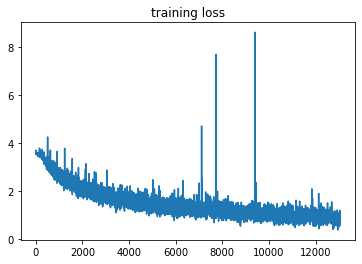

In [16]:
plt.plot(storage['losses'][5:]);
plt.title("training loss");